In [1]:
%matplotlib inline
from construct import *
import numpy as np
import subprocess
import sys
import matplotlib.pyplot as plt
import pandas as pd
import struct

SSDV_PATH = 'ssdv'
# SSDV_PATH = '/Users/dijkema/Desktop/dslwp/ssdv/ssdv/ssdv'

In [2]:
TMPrimaryHeader = BitStruct('transfer_frame_version_number' / BitsInteger(2),
                            'spacecraft_id' / BitsInteger(10),
                            'virtual_channel_id' / BitsInteger(3),
                            'ocf_flag' / Flag,
                            'master_channel_frame_count' / BitsInteger(8),
                            'virtual_channel_frame_count' / BitsInteger(8),
                            'first_header_pointer' / BitsInteger(8))

In [3]:
def seqnum(packet):
    return packet[1]*256 + packet[2]

def unwrap(seqnums):
    count = 0
    for j,x in enumerate(seqnums):
        if x >= 240:
            count += 1
            if count == 5:
                location = j
                break
        else:
            count = 0
    s = seqnums.copy().astype('int')
    s[location:][s[location:] < 230] += 256
    return s

def crc32(data, initial_value = 0):
    """Implementation taken from crc32() in ssdv.c"""
    crc = initial_value
    for d in data:
        x = (crc ^ d) & 0xFF
        for _ in range(8):
            if x & 1:
                x = (x >> 1) ^ 0xEDB88320
            else:
                x >>= 1
        crc = (crc >> 8) ^ x
    return crc ^ 0xFFFFFFFF

def check_ssdv_crc(frame):
    return crc32(frame[5:-4], 0x4EE4FDE1) == struct.unpack('>I', frame[-4:])[0]

def process_ssdv_frames(frames, output_path):
    x = np.frombuffer(bytes().join(frames), dtype = 'uint8').reshape((-1,223))[:,5:]
    seq = unwrap(x[:,0])
    ids = set(seq)
    for i in ids:
        l = list(x[seq==i,:])
        l.sort(key=seqnum)
        ssdv = '{}_{}.ssdv'.format(output_path, i)
        jpeg = '{}_{}.jpg'.format(output_path, i)
        np.array(l).tofile(ssdv)
        subprocess.call([SSDV_PATH, '-d', '-D', ssdv, jpeg])

In [4]:
frames = pd.read_csv('raw_frame.csv')
frames['raw_data'] = frames['raw_data'].apply(bytes().fromhex)
frames['is_ssdv'] = [TMPrimaryHeader.parse(frame).virtual_channel_id == 1 \
                     and check_ssdv_crc(frame) for frame in frames['raw_data']]

In [5]:
with open('raw_frame.csv') as f:
    frameslist = [bytes().fromhex(l.split(',')[-1].strip()) for l in f.readlines()[1:]]

In [6]:
process_ssdv_frames(frames[frames['is_ssdv']]['raw_data'].values, 'output/img')

In [7]:
frames['image_id'] = 0
raw_data = np.frombuffer(bytes().join(frames['raw_data'].values), dtype='uint8').reshape((-1,223))
frames['image_id'] = raw_data[:,5]

In [8]:
def to_numpy_array(byteslist):
    return np.frombuffer(bytes().join(byteslist), dtype='uint8').reshape((-1,223))

In [9]:
frames['imageID'] = -1

In [10]:
frames.loc[frames['is_ssdv'], 'imageID'] = \
    unwrap(to_numpy_array(frames[frames['is_ssdv']]['raw_data'].values)[:,5])

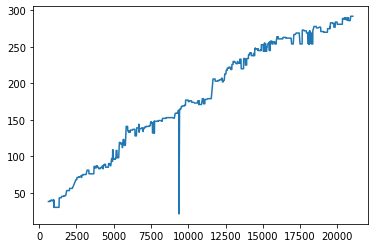

In [11]:
plt.plot(frames[frames['is_ssdv']]['imageID']);

In [12]:
for imageID in range(300):
    imageframes = frames[frames['imageID']==imageID]
    if len(imageframes) > 0:
        contributors = np.unique(frames[frames['imageID']==imageID]['proxy_nickname'].values)
        print(f"{imageID}\t" + ", ".join(contributors))

21	test_BY2HIT
30	PI9CAM, beijing
38	PI9CAM, beijing
39	beijing
40	beijing
43	PI9CAM
45	DK3WN, PI9CAM, YL3CT
46	DK3WN, PI9CAM, YL3CT
53	4Z5CP, PI9CAM, PI9CAM-V
56	PI9CAM, PI9CAM-V
68	PI9CAM, YL3CT
71	PI9CAM, YL3CT
72	PI9CAM, YL3CT
73	PI9CAM, YL3CT
74	N6RFM, PI9CAM, YL3CT
75	N6RFM, PI9CAM, YL3CT
76	DK3WN, PI9CAM, PI9CAM-V, YL3CT
81	PI9CAM, PI9CAM-V, YL3CT
83	PI9CAM, YL3CT
84	DK3WN, PI9CAM, YL3CT
85	DK3WN, PI9CAM, PI9CAM-V, YL3CT
86	DK3WN, YL3CT
87	DK3WN, PI9CAM, YL3CT
88	PI9CAM, YL3CT
89	PI9CAM, PI9CAM-V
90	PI9CAM, PI9CAM-V
93	PI9CAM-WEBSDR
96	PI9CAM
97	PI9CAM, PI9CAM-WEBSDR
98	PI9CAM, PI9CAM-V
108	PI9CAM, PI9CAM-V, PI9CAM-WEBSDR
109	PI9CAM
112	PI9CAM
115	DK3WN, PI9CAM, PI9CAM-WEBSDR, YL3CT
117	DK3WN, PI9CAM
118	PI9CAM
119	DK3WN, PI9CAM
123	DK3WN, PI9CAM, PI9CAM-WEBSDR
128	PI9CAM, PI9CAM-V
132	PI9CAM
133	PI9CAM
134	PI9CAM
135	PI9CAM
136	PI9CAM, PI9CAM-V
137	PI9CAM, PI9CAM-V
138	PI9CAM, PI9CAM-WEBSDR, YL3CT
139	PI9CAM, PI9CAM-V, PI9CAM-WEBSDR, YL3CT
140	PI9CAM, PI9CAM-WEBSDR, YL3CT
141	P

In [13]:
pd.get_option('display.max_rows')

60

In [14]:
pd.set_option('display.max_rows', None)
print(frames[frames['is_ssdv']].groupby('imageID')['proxy_receive_time'].max())
pd.set_option('display.max_rows', 60)

imageID
21     2018-12-14 13:55:41.297
30     2018-08-12 16:03:46.000
38     2018-08-05 08:54:03.772
39     2018-08-05 09:52:14.876
40     2018-08-05 10:05:00.231
43     2018-08-12 16:52:10.800
45     2018-08-14 18:14:38.200
46     2018-08-14 18:59:51.128
53     2018-09-14 23:29:42.598
56     2018-09-15 00:27:29.729
68     2018-10-07 18:32:38.288
71     2018-10-08 18:20:32.993
72     2018-10-08 17:10:45.643
73     2018-10-08 17:46:06.101
74     2018-10-10 22:21:48.794
75     2018-10-10 23:11:22.723
76     2018-10-14 22:15:53.129
81     2018-10-14 21:02:29.282
83     2018-10-18 01:57:16.806
84     2018-10-18 01:11:31.258
85     2018-10-19 01:58:49.689
86     2018-10-17 00:25:07.709
87     2018-10-20 01:45:10.117
88     2018-10-19 00:52:10.810
89     2018-10-19 02:29:57.325
90     2018-10-19 02:23:34.227
93     2018-10-24 03:39:45.740
96     2018-10-26 04:12:23.178
97     2018-10-26 04:35:52.592
98     2018-10-27 14:05:53.524
108    2018-10-27 13:23:03.695
109    2018-10-26 03:18:09.251
